<a href="https://colab.research.google.com/github/victoryobieke/Nonlinear-Schrodinger/blob/main/Schrodinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install deepxde**  
Tensorflow and all other dependencies are already installed in Colab terminals

**Problem setup**  
  
We are going to solve the non-linear Schrödinger equation given by  
$i h_t + \frac{1}{2} h_{xx} + |h|^2h = 0$  
  
with periodic boundary conditions as  
$x \in [-5,5], \quad t \in [0, \pi/2]$  
$h(t, -5) = h(t,5)$  
$h_x(t, -5) = h_x(t,5)$  
  
and initial condition equal to  
$h(0,x) = 2 sech(x)$



In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.3 MB/s eta 0:00:00


Deepxde only uses real numbers, so we need to explicitly split the real and imaginary parts of the complex PDE.  
  
In place of the single residual  
$f = ih_t + \frac{1}{2} h_{xx} +|h|^2 h$  
  
we get the two (real valued) residuals  
$f_{\mathcal{R}} = u_t + \frac{1}{2} v_{xx} + (u^2 + v^2)v$  
$f_{\mathcal{I}} = v_t - \frac{1}{2} u_{xx} - (u^2 + v^2)u$  
  
where u(x,t) and v(x,t) denote respectively the real and the imaginary part of h.  


In [ ]:
from google.colab import drive
import numpy as np
import scipy.io
import deepxde as dde


# For plotting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi / 2

# Creation of the 2D domain (for plotting and input)
x = np.linspace(x_lower, x_upper, 400)
t = np.linspace(t_lower, t_upper, 300)
X, T = np.meshgrid(x, t)

# The whole domain flattened
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Space and time domains/geometry (for the deepxde model)
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [ ]:
# The "physics-informed" part of the loss


def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """

    u = y[:, 0:1] #slicing to inforce that size(u) = [nx, 1] ( (nx, ))
    v = y[:, 1:2]

    # In 'jacobian', i is the output component and j is the input component
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    # In 'hessian', i and j are both input components. (The Hessian could be in principle something like d^2y/dxdt, d^2y/d^2x etc)
    # The output component is selected by "component"
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    return [f_u, f_v]

In [ ]:
import numpy as np

def compute_mass(u, v, dx):
    """
    Compute the mass of the solution.

    Args:
        u: Real part of the solution.
        v: Imaginary part of the solution.
        dx: Spatial grid spacing.

    Returns:
        Mass of the solution.
    """
    abs_h_squared = u**2 + v**2
    mass = np.sum(abs_h_squared) * dx
    return mass


In [ ]:
def compute_hamiltonian(u, v, u_xx, v_xx, dx):
    """
    Compute the Hamiltonian of the solution.

    Args:
        u: Real part of the solution.
        v: Imaginary part of the solution.
        u_xx: Second derivative of the real part of the solution.
        v_xx: Second derivative of the imaginary part of the solution.
        dx: Spatial grid spacing.

    Returns:
        Hamiltonian of the solution.
    """
    # Compute |∂_xx h|^2
    abs_h_xx_squared = u_xx**2 + v_xx**2

    # Compute |h|^4
    abs_h_squared = u**2 + v**2
    abs_h_quartic = abs_h_squared**2

    # Hamiltonian
    hamiltonian = np.sum(abs_h_xx_squared) * dx - (1 / 4) * np.sum(abs_h_quartic) * dx
    return hamiltonian


In [ ]:
# Boundary and Initial conditions

# Periodic Boundary conditions
bc_u_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)

# Initial conditions
def init_cond_u(x):
    return np.sqrt(2) / np.cosh(np.sqrt(2) * x[:, 0:1])


def init_cond_v(x):
    return 0


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

In [ ]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=2000, # Nf ?
    num_boundary=50, # Nb ?
    num_initial=50, # N0 ?
    train_distribution="pseudo",
)# Dataset

# Network architecture
net = dde.nn.FNN([2] + [128] * 4 + [2], "tanh", "Glorot uniform")
# net = dde.nn.FNN([2] + [100] * 4 + [2], "tanh", "He normal")
# net = dde.nn.FNN([2] + [100] * 4 + [2], "tanh", "He normal")
#net = dde.nn.FNN([2] + [128] * 4 + [2], "tanh", "Glorot normal")
#[number of input data] + [number of neurons]*(number of hiddenlayers+1) + [number of ouput data], "activation function", "activation function for initialization layer?"

model = dde.Model(data, net)# NN model

Adam optimization.  I changed it to rmsprop

---



In [ ]:
# To employ a GPU accelerated system is highly encouraged.

# model.compile("adam", lr=1e-2+0.05/2, loss="MAE") #"optimizer", lr=learning rate,
# model.compile("adam", lr=2e-2, loss="MAE") #"optimizer", lr=learning rate,
model.compile("adam", lr=2e-1, loss="MAE")
# model.compile("rmsprop", lr=1e-3, loss="MSE")
# model.compile("rmsprop", lr=1e-3, loss="MSE")
model.train(iterations=10000, display_every=1000)
#how to add the mass/hamiltonian loss ?

Compiling model...
Building feed-forward neural network...
'build' took 0.092885 s

'compile' took 2.020739 s

Training model...

0         [4.20e-02, 2.31e-02, 3.02e-01, 4.80e-03, 3.88e-01, 3.38e-03, 3.33e-01, 1.48e-01]    [4.20e-02, 2.31e-02, 3.02e-01, 4.80e-03, 3.88e-01, 3.38e-03, 3.33e-01, 1.48e-01]    []  
1000      [5.51e-04, 4.35e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.27e-01, 6.97e-02]    [5.51e-04, 4.35e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.27e-01, 6.97e-02]    []  
2000      [8.89e-03, 7.66e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.34e-01, 2.07e-01]    [8.89e-03, 7.66e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.34e-01, 2.07e-01]    []  
3000      [1.39e-02, 7.11e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 3.60e-01, 2.22e-01]    [1.39e-02, 7.11e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 3.60e-01, 2.22e-01]    []  
4000      [2.26e-06, 1.16e-04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.27e-01, 9.49e-04]    [2.26e-06, 1.16e-04, 0.00e+00, 0.00e+00, 0.0

(<deepxde.model.LossHistory at 0x7be10276c4d0>,
 <deepxde.model.TrainState at 0x7be102a6e6d0>)

L-BFGS optimization.

In [49]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=500,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=500,
)
model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 2.114930 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
10000     [1.09e-07, 4.48e-08, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.16e-01, 3.80e-03]    [1.09e-07, 4.48e-08, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.16e-01, 3.80e-03]    []  
10016     [1.09e-07, 4.48e-08, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.16e-01, 3.80e-03]    [1.09e-07, 4.48e-08, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.16e-01, 3.80e-03]    []  

Best model at step 10000:
  train loss: 2.20e-01
  test loss: 2.20e-01
  test metric: []

'train' took 12.967148 s



(<deepxde.model.LossHistory at 0x7be10276c4d0>,
 <deepxde.model.TrainState at 0x7be102a6e6d0>)

Final results.  
The reference solution and further information can be found in [this paper](https://arxiv.org/abs/1711.10561) from Raissi, Karniadakis, Perdikaris.  
The test data can be got [here](https://github.com/maziarraissi/PINNs/blob/master/main/Data/NLS.mat).

In [44]:
from scipy.interpolate import griddata

# Physics-informed PDE
def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The PDE residuals in standard form.
    """
    u = y[:, 0:1]  # Real part
    v = y[:, 1:2]  # Imaginary part

    # Gradients
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    # PDE equations
    f_u = u_t + 0.5 * v_xx + (u**2 + v**2) * v
    f_v = v_t - 0.5 * u_xx - (u**2 + v**2) * u

    return [f_u, f_v]

# Compute Mass
def compute_mass(u, v, dx):
    """
    Compute the mass of the solution at each time step.

    Args:
        u: Real part of the solution (2D array: spatial x time).
        v: Imaginary part of the solution (2D array: spatial x time).
        dx: Spatial grid spacing (scalar).

    Returns:
        Mass at each time step (1D array).
    """
    abs_h_squared = u**2 + v**2  # Pointwise |h|^2
    mass = np.sum(abs_h_squared, axis=0) * dx  # Sum over spatial dimension
    return mass

# Compute Hamiltonian
def compute_hamiltonian(u, v, u_xx, v_xx, dx):
    """
    Compute the Hamiltonian of the solution at each time step.

    Args:
        u: Real part of the solution (2D array: spatial x time).
        v: Imaginary part of the solution (2D array: spatial x time).
        u_xx: Second derivative of u (2D array: spatial x time).
        v_xx: Second derivative of v (2D array: spatial x time).
        dx: Spatial grid spacing (scalar).

    Returns:
        Hamiltonian at each time step (1D array).
    """
    abs_h_xx_squared = u_xx**2 + v_xx**2
    abs_h_squared = u**2 + v**2
    abs_h_quartic = abs_h_squared**2
    hamiltonian = (
        np.sum(abs_h_xx_squared, axis=0) * dx
        - (1 / 4) * np.sum(abs_h_quartic, axis=0) * dx
    )
    return hamiltonian

# After training the model, make predictions
prediction = model.predict(X_star)  # Predicted outputs
u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")  # Real part
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")  # Imaginary part

# Compute grid spacing
dx = np.diff(X[0, :])[0]  # Assuming uniform grid
print("dx:", dx)

# Compute second derivatives for Hamiltonian
u_xx = np.gradient(np.gradient(u, dx, axis=0), dx, axis=0)
v_xx = np.gradient(np.gradient(v, dx, axis=0), dx, axis=0)

# Compute mass and Hamiltonian
mass = compute_mass(u, v, dx)
hamiltonian = compute_hamiltonian(u, v, u_xx, v_xx, dx)

# Print results
print("Mass:", mass)
print("Mass shape:", mass.shape)  # Should be (n_t,)
print("Hamiltonian:", hamiltonian)
print("Hamiltonian shape:", hamiltonian.shape)  # Should be (n_t,)


dx: 0.02506265664160434
Mass: [0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342 0.04032342
 0.04032342 0.04032342 0.0403234

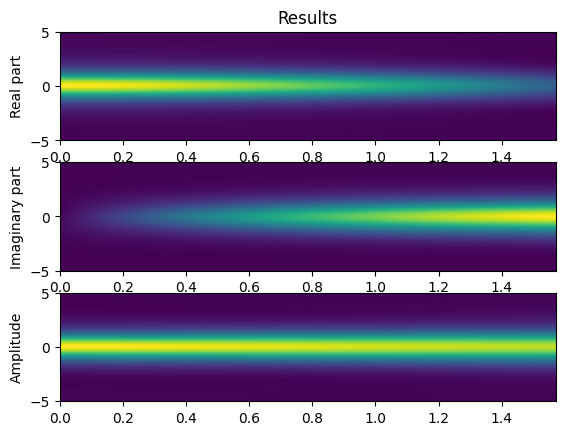

In [ ]:
# Make prediction
prediction = model.predict(X_star, operator=None)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
scipy.io.savemat('file4.mat', {'matrix_nameu':u})
scipy.io.savemat('file5.mat', {'matrix_namev':v})

h = np.sqrt(u ** 2 + v ** 2)
scipy.io.savemat('file9.mat', {'matrix_name':h})

# Plot predictions
fig, ax = plt.subplots(3)

ax[0].set_title("Results")
ax[0].set_ylabel("Real part")
ax[0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part")
ax[1].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude")
ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

plt.show()

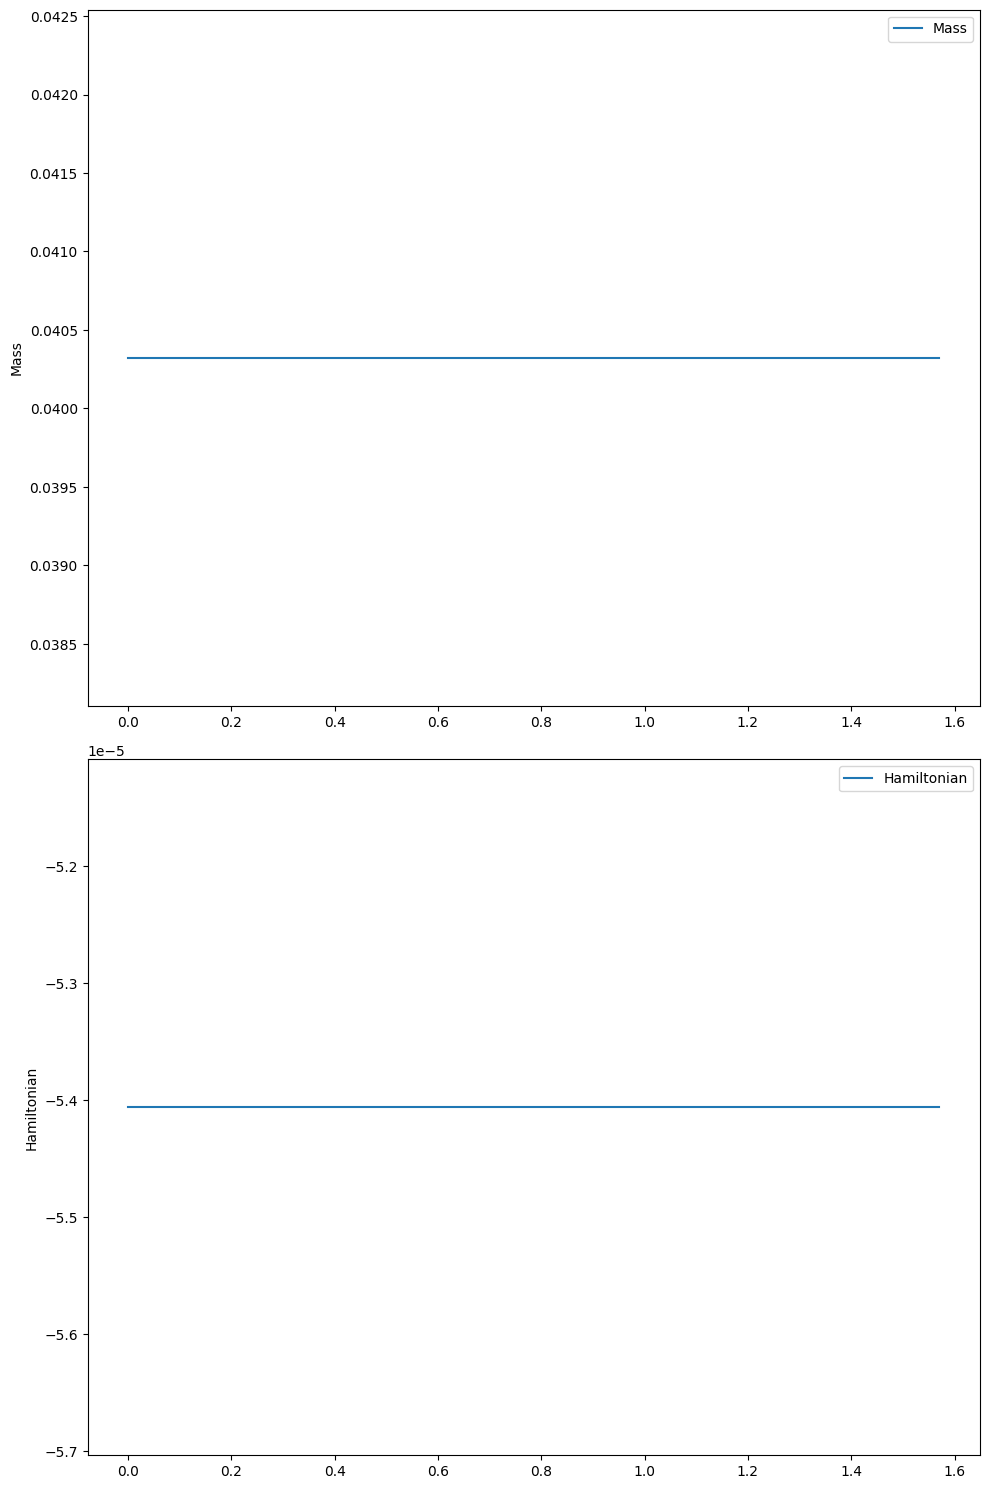

In [48]:
fig, ax = plt.subplots(2, figsize=(10, 15))  # 2 plots: Mass and Hamiltonian

# Plot Mass
ax[0].set_ylabel("Mass")
ax[0].plot(np.linspace(t_lower, t_upper, mass.shape[0]), mass, label="Mass")
ax[0].legend()

# Plot Hamiltonian
ax[1].set_ylabel("Hamiltonian")
ax[1].plot(np.linspace(t_lower, t_upper, hamiltonian.shape[0]), hamiltonian, label="Hamiltonian")
ax[1].legend()

plt.tight_layout()
plt.show()


# New Section

**Assess the accuracy**

We can employ the test data to assess the accuracy of the trained model.  
Using the normalized $L^2$ norm defined as  
  
Error $u$ = $\frac{1}{||u_{test}||_{L^2}} ||u_{test} - u_{pred}||_{L^2}$  
  
where $u_{test}$ is the reference solution and $u_{pred}$ is the prediction given by the model, we get:  
  
Error $u$: 1.854433e-03  
Error $v$: 2.413796e-03  
Error $h$: 1.426797e-03  
  
We can also plot the absolute value of the error for each point of the domain. It's everywhere in the order E-3.  






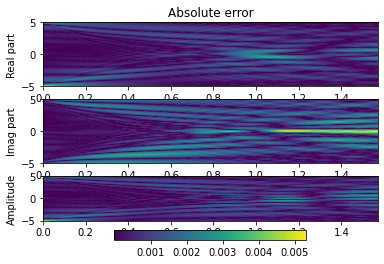